# Using Metadensity with skipper outputs
[Skipper](https://github.com/YeoLab/skipper) is a new eCLIP pipeline that is faster and more sensitive. 

Technically, Metadensity does not care how the bigwig files/bed/bams files are generated. Therefore, whether you process the data with skipper, or ENCODE pipeline, or whatever pipeline you wrote, as long as the file formats (.bigwig, .bam, .bed) are right, Metadensity runs.

This notebook offers a shortcut for users that finds python annoying to copy paste from.

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/home/hsher/projects/Metadensity/config/hg38.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/projects/Metadensity/scripts')
from dataloader import *
%matplotlib inline

plt.style.use('seaborn-white')

please set the right config according to genome coordinate
Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


## load RBPs into eCLIP object from Skipper outputs

Notice the bigwig files skipper produce are 'read truncation counts', which is different from the coverage track from encode pipeline. Therefore, it is sparser than read coverage. the plot looks more noisy than coverage bigwig tracks. To calculate coverage tracks instead, you can make use of rules in [here](https://github.com/algaebrown/make_track/blob/master/Snake_CLIP_track.py)

In [2]:
from pathlib import Path
skipper_output_dir = Path('/projects/ps-yeolab5/encore/processing/skipper_output/')

In [3]:
def get_file_path(prefix, skipper_output_dir, ip_suffix = '_IP_',
                 in_suffix = '_IN_', rep = 1):
    return pd.Series({'uid':prefix+f'_rep{rep}',
               'RBP': prefix+f'_rep{rep}',
               'bam_0': str(skipper_output_dir/'bams'/'dedup'/'genome'/f'{prefix}{ip_suffix}{rep}.genome.Aligned.sort.dedup.bam'),
               'bam_control_0':str(skipper_output_dir/'bams'/'dedup'/'genome'/f'{prefix}{in_suffix}{rep}.genome.Aligned.sort.dedup.bam'),
               'minus_0': str(skipper_output_dir / 'bigwigs' / 'minus' / f'{prefix}{ip_suffix}{rep}.minus.bw'),
               'minus_control_0': str(skipper_output_dir / 'bigwigs' / 'minus' / f'{prefix}{in_suffix}{rep}.minus.bw'),
               'plus_0': str(skipper_output_dir / 'bigwigs' / 'plus' / f'{prefix}{ip_suffix}{rep}.plus.bw'),
               'plus_control_0': str(skipper_output_dir / 'bigwigs' / 'plus' / f'{prefix}{in_suffix}{rep}.plus.bw')
              }
             )

In [4]:
# check if files exist.
# if your bigwigs don't exist, need to uncomment the rule all output bigwig/ line
get_file_path('4001', skipper_output_dir).apply(os.path.isfile)

uid                False
RBP                False
bam_0               True
bam_control_0       True
minus_0             True
minus_control_0     True
plus_0              True
plus_control_0      True
dtype: bool

In [5]:
e = eCLIP.from_series(get_file_path('4212', skipper_output_dir))


# The reason I did not put enriched windows into `bed_*` and `idr_` is because their format is not really a bed file
and that will crash Metadensity, as it is using BedTool.
alternatively, I would use `transcripts=` kwargs to specify the transcripts containing reproducible windows

In [6]:
from itertools import chain
def find_gene_ids_with_reproducible_windows(prefix, skipper_output_dir):
    window_path = skipper_output_dir / 'reproducible_enriched_windows' / f'{prefix}.reproducible_enriched_windows.tsv.gz'
    window = pd.read_csv(window_path, sep = '\t')
    
    # find genes with reproducible windows. Some windows contain >1 gene id. `chain` flattens the list of list
    # chain https://www.geeksforgeeks.org/python-itertools-chain/
    gene_with_windows = list(set(chain(*window['gene_id'].apply(lambda idlist: idlist.split(':')).tolist())))
    
    # skipper is run with gencode v38 which is different from metadensity's version. need some conversion
    # remove version
    geneid_no_version = [g.split('.')[0] for g in gene_with_windows] # this is list comprehension. lazy and short for loops
    # map to Metadensity's version
    metadensity_gene_ids = [t.attrs['gene_id'] for t in transcript if t.attrs['gene_id'].split('.')[0] in geneid_no_version]
    return metadensity_gene_ids

In [7]:
geneids = find_gene_ids_with_reproducible_windows('SNRNP200_HepG2', skipper_output_dir)

In [8]:
# here for the set of transcript, we use the IDR peak containing transcript assuming they have good signal
m = Metadensity(e, e.name,background_method = 'relative information', normalize = False, transcript_ids = geneids)
m.get_density_array()


Using: /home/hsher/projects/Metadensity/metadensity/data/hg38/gencode
Done building metagene


Text(0, 0.5, 'mean relative information')

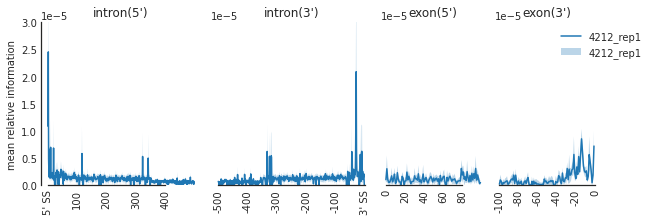

In [9]:
f=plot_mean_density([m],
                    features_to_show = ['intron', 'exon'], ymax = 0.00003)
f=beautify(f, offset = 0) # sns.despine 
f.get_axes()[0].set_ylabel('mean relative information')